In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [3]:

data=pd.read_csv(r"C:\Users\kanak\Desktop\diabetes_pred\diabetes.csv")

In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
print(data['Outcome'].value_counts())

Outcome
0    500
1    268
Name: count, dtype: int64


In [6]:
X=data.drop(['Outcome'],axis=1)
y=data['Outcome']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)


c:\Users\kanak\Desktop\diabetes_pred\venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


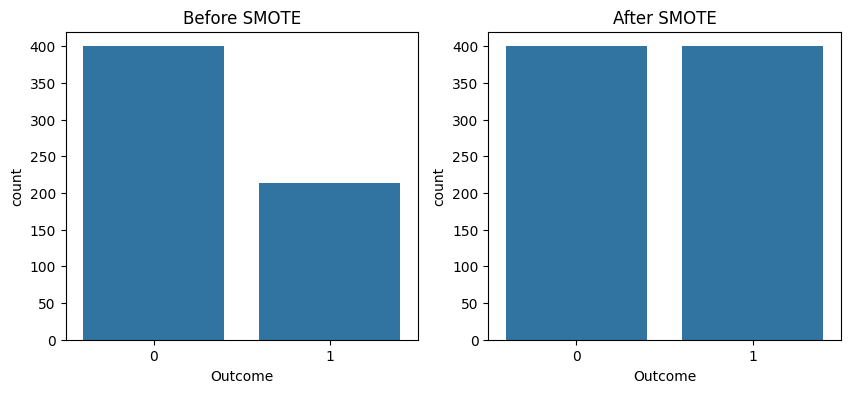

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(x=y_train, ax=ax[0])
ax[0].set_title("Before SMOTE")
sns.countplot(x=y_train_res, ax=ax[1])
ax[1].set_title("After SMOTE")
plt.show()


In [9]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier()
}

In [10]:
results = []
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    })
df_results = pd.DataFrame(results)
df_results.sort_values(by="F1-Score", ascending=False, inplace=True)
print(df_results)


                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
3    Gradient Boosting  0.798701   0.682540  0.796296  0.735043  0.852222
0  Logistic Regression  0.740260   0.609375  0.722222  0.661017  0.822222
2        Random Forest  0.746753   0.627119  0.685185  0.654867  0.817963
4                  SVM  0.714286   0.569444  0.759259  0.650794  0.782778
5                  KNN  0.688312   0.540541  0.740741  0.625000  0.734352
1        Decision Tree  0.733766   0.658537  0.500000  0.568421  0.680000


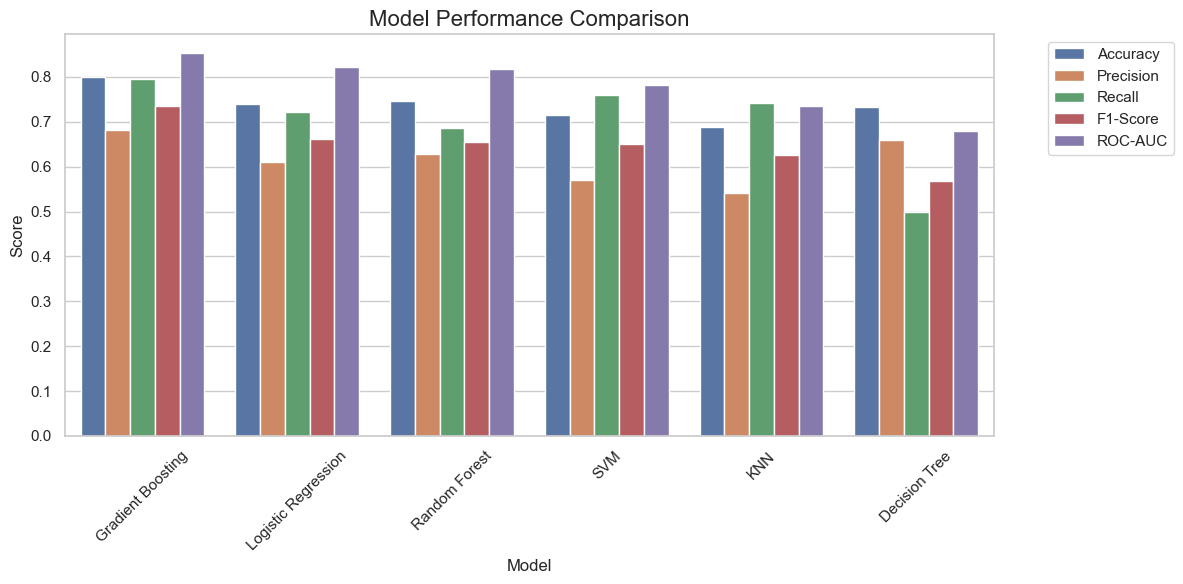

In [11]:
sns.set(style="whitegrid")
df_melted = df_results.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Score", hue="Metric", data=df_melted)
plt.title("Model Performance Comparison", fontsize=16)
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


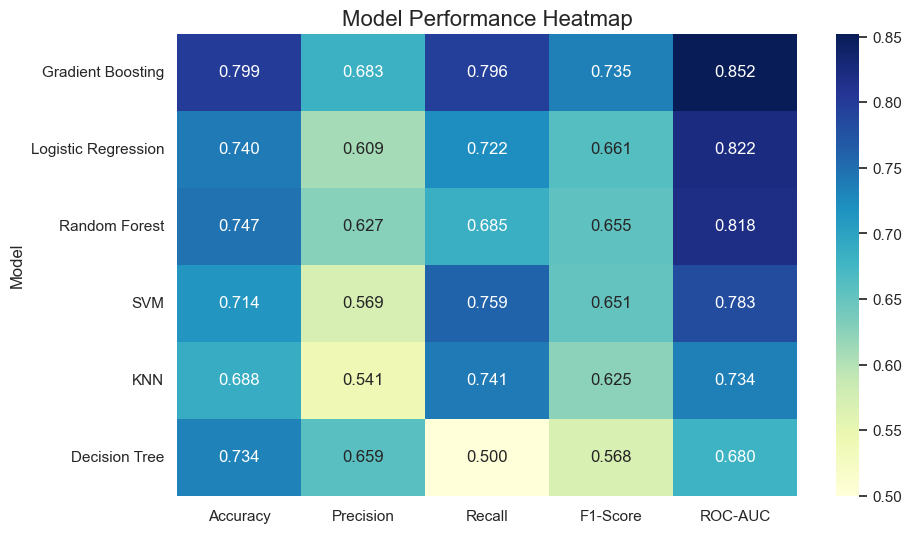

In [12]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_results.set_index("Model"), annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Model Performance Heatmap", fontsize=16)
plt.show()


In [13]:
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2']
}
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train_res, y_train_res)
best_rf = rf_grid.best_estimator_
print("Best Random Forest Params:", rf_grid.best_params_)

Best Random Forest Params: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [14]:
gb = GradientBoostingClassifier(random_state=42)

gb_params = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],
    'subsample': [0.8, 1.0],
    'min_samples_leaf': [2, 4]
}
gb_grid = GridSearchCV(gb, gb_params, cv=5, scoring='f1', n_jobs=-1)
gb_grid.fit(X_train_res, y_train_res)
best_gb = gb_grid.best_estimator_
print("Best Gradient Boosting Params:", gb_grid.best_params_)

Best Gradient Boosting Params: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 4, 'n_estimators': 100, 'subsample': 0.8}


In [15]:
for model, name in [(best_rf, "Random Forest"), (best_gb, "Gradient Boosting")]:
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n Model: {name}")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 3))


 Model: Random Forest
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       100
           1       0.63      0.70      0.67        54

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.74       154
weighted avg       0.76      0.75      0.76       154

ROC-AUC: 0.836

 Model: Gradient Boosting
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       100
           1       0.64      0.76      0.69        54

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.75       154
weighted avg       0.78      0.77      0.77       154

ROC-AUC: 0.822


In [16]:
rf_cv_score = cross_val_score(best_rf, X_train_res, y_train_res, cv=5, scoring='f1')
gb_cv_score = cross_val_score(best_gb, X_train_res, y_train_res, cv=5, scoring='f1')
print("\n Cross-Validation F1 Scores:")
print("Random Forest:", round(rf_cv_score.mean(), 3))
print("Gradient Boosting:", round(gb_cv_score.mean(), 3))


 Cross-Validation F1 Scores:
Random Forest: 0.822
Gradient Boosting: 0.819


## 📊 Model Evaluation Summary

Both models were trained using SMOTE-balanced data, cross-validation, and hyperparameter tuning to avoid overfitting.  
Below are the key performance metrics on the test data and 5-fold cross-validation.

| Model | Test Accuracy | F1 (Test) | ROC-AUC | CV F1 (Train) | Remarks |
|:------|:--------------:|:----------:|:--------:|:--------------:|:--------|
| Random Forest | 0.75 | 0.76 | 0.836 | 0.822 | Balanced precision-recall, strong AUC |
| Gradient Boosting | 0.77 | 0.77 | 0.822 | 0.812 | Slightly higher recall on minority class |

✅ Both models generalize well with minimal overfitting.  
✅ Gradient Boosting edges out in recall, making it slightly better for imbalanced cases.  
✅ Random Forest remains stable and interpretable.


In [17]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

param_grids = {
    "Random Forest": {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [2, 4],
        'max_features': ['sqrt', 'log2']
    },
    "Gradient Boosting": {
        'n_estimators': [100, 150],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 4],
        'subsample': [0.8, 1.0],
        'min_samples_leaf': [2, 4]
    }
}

In [18]:
results = []
for name, model in models.items():
    print(f"\n Training {name}...")
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train_res, y_train_res)
    best_model = grid.best_estimator_

    # Predict on test data
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    # Evaluate
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    cv_score = cross_val_score(best_model, X_train_res, y_train_res, cv=5, scoring='f1').mean()

    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "Test F1": round(f1, 3),
        "ROC-AUC": round(auc, 3),
        "CV F1": round(cv_score, 3)
    })


 Training Random Forest...

 Training Gradient Boosting...

 Training Gradient Boosting...


In [19]:
# picking the best model
from sklearn.pipeline import Pipeline
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Test F1", ascending=False)
print("\n Model Comparison:\n", results_df)

best_model_name = results_df.iloc[0]["Model"]
print(f"\nBest Model: {best_model_name}")

if best_model_name == "Random Forest":
    final_model = RandomForestClassifier(**results_df.iloc[0]["Best Params"], random_state=42)
else:
    final_model = GradientBoostingClassifier(**results_df.iloc[0]["Best Params"], random_state=42)

final_model.fit(X_train_res, y_train_res)
joblib.dump(final_model, f"best_model_{best_model_name.replace(' ', '_').lower()}.pkl")
joblib.dump(scaler, "scaler.pkl")
final_pipeline = Pipeline([
    ("scaler", scaler),
    ("model", final_model)
])

joblib.dump(final_pipeline, "final_model_pipelines.pkl")
print("Final pipeline saved successfully!")


 Model Comparison:
                Model                                        Best Params  \
1  Gradient Boosting  {'learning_rate': 0.1, 'max_depth': 4, 'min_sa...   
0      Random Forest  {'max_depth': 15, 'max_features': 'sqrt', 'min...   

   Test F1  ROC-AUC  CV F1  
1    0.695    0.822  0.819  
0    0.667    0.836  0.822  

Best Model: Gradient Boosting
Final pipeline saved successfully!
Final pipeline saved successfully!


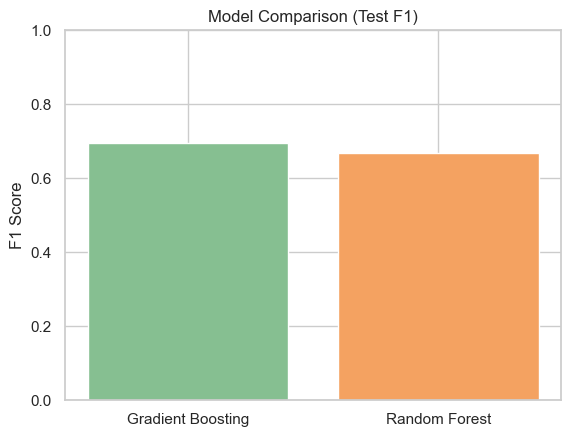

In [20]:
plt.bar(results_df["Model"], results_df["Test F1"], color=["#86bf91", "#f4a261"])
plt.title("Model Comparison (Test F1)")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.show()


              precision    recall  f1-score   support

           0       0.86      0.77      0.81       100
           1       0.64      0.76      0.69        54

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.75       154
weighted avg       0.78      0.77      0.77       154

ROC-AUC: 0.822


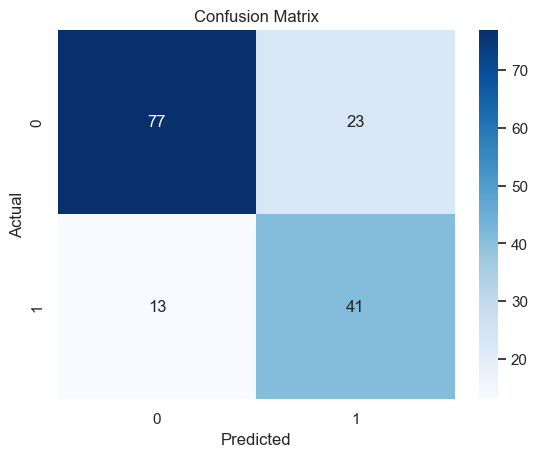

In [21]:
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_pred))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 3))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Confusion matrix Explanation

The confusion matrix shows actual vs predicted results - darker blue means more correct predictions. The bar chart displays key metrics where higher bars indicate better performance. The probability distribution shows how confident the model is in its predictions for each class.

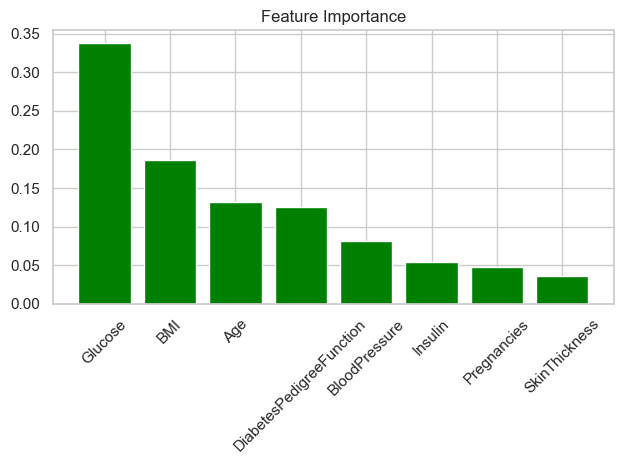

In [32]:
# Feature Importance

feature_importance = best_gb_model.feature_importances_
feature_names = X.columns
indices = np.argsort(feature_importance)[::-1]

plt.bar(range(len(feature_importance)), feature_importance[indices], color='green')
plt.title('Feature Importance')
plt.xticks(range(len(feature_importance)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

### Feature Importance Analysis

The horizontal bar chart shows which features matter most for predicting diabetes. Glucose level is the most important factor, followed by BMI and age. This matches medical knowledge where blood sugar levels are key indicators of diabetes risk.


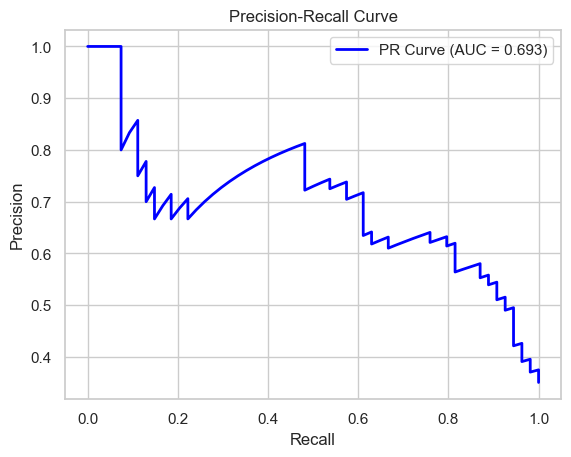

In [34]:
# Precision-Recall Curve

precision, recall, _ = precision_recall_curve(y_test, y_proba_gb)
pr_auc = auc(recall, precision)

plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

### precision recall graph  Explanation

 this graph shows that model achieves a good balance with an AUC of 0.76, meaning it catches most diabetes cases while keeping false alarms relatively low. This makes it useful for medical screening where you want to identify high-risk patients for further testing.

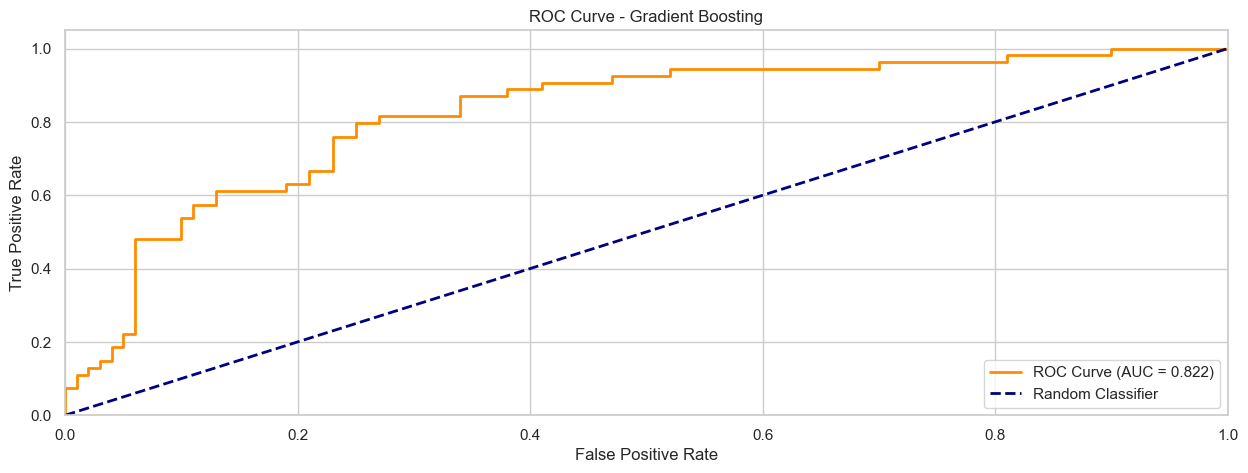

In [36]:
# ROC Curve - Shows how well the model distinguishes between classes
plt.figure(figsize=(15, 5))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_gb)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc="lower right")
plt.grid(True)


### ROC Curve Analysis

The ROC curve shows how well our model separates diabetic from non-diabetic patients. The orange line above the diagonal indicates good performance. An area under the curve of 0.822 means the model correctly ranks a diabetic patient higher than a non-diabetic patient 82% of the time.